# Classificador de empréstimo (loanKNN)

Usando o PyData Stack e o SKLearn será treinado e avaliado um modelo preditivo de classificação com objetivo de ajudar na tomada de decisão para concessão de empréstimos. O DataSample vem do dataset [Loan Data](https://www.kaggle.com/zhijinzhai/loandata) disponível no Kaggle, está estruturado da seguinte forma:

* Loan_id: Valor unico que identifica cada cliente de empréstimo;

* Loan_status: Se o empréstimo foi pago (PAIDOFF) ou está em cobrança (COLLECTION) ou se foi pago após cobrança (COLLECTION_PAIDOFF);

* Principal: Valor principal do empréstimo;

* terms: pode ter agenda de pagamentos semanal (7) bisemanal (15) ou mensal (30);

* Effective_date: quando o empréstimo foi originado;

* Due_date: data de vencimento;

* Paidoff_time: tempo levado pelo cliente para pagar o empréstimo;

* Pastdue_days: dias passados do vencimento;

* Age, education, gender: dados demográficos dos clientes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns
import itertools
from sklearn import preprocessing

%matplotlib inline

# Preparando o DataSample

In [13]:
df = pd.read_csv('data/loanPayments.csv', sep = ',')

print(df.head())

print(df.shape)

       Loan_ID loan_status  Principal  terms effective_date   due_date  \
0  xqd20166231     PAIDOFF       1000     30       9/8/2016  10/7/2016   
1  xqd20168902     PAIDOFF       1000     30       9/8/2016  10/7/2016   
2  xqd20160003     PAIDOFF       1000     30       9/8/2016  10/7/2016   
3  xqd20160004     PAIDOFF       1000     15       9/8/2016  9/22/2016   
4  xqd20160005     PAIDOFF       1000     30       9/9/2016  10/8/2016   

     paid_off_time  past_due_days  age             education  Gender  
0  9/14/2016 19:31            NaN   45  High School or Below    male  
1   10/7/2016 9:00            NaN   50              Bechalor  female  
2  9/25/2016 16:58            NaN   33              Bechalor  female  
3  9/22/2016 20:00            NaN   27               college    male  
4  9/23/2016 21:36            NaN   28               college  female  
(500, 11)


Algumas das colunas não são interessantes para o objetivo final: Loan_ID, past_due_days, paid_off_time. Além disso é importante formatar os datatypes das colunas restantes que contêm datas: effective_due e due_date

In [14]:
df.drop(columns = ['Loan_ID', 'past_due_days', 'paid_off_time'], inplace = True) #remove as colunas Loan_ID, past_due_days e paid_off_time

df.effective_date = pd.to_datetime(df.effective_date) #converte effective_data para formato datetime
df.due_date = pd.to_datetime(df.due_date) # converte due_date para formato datetime

print(df.head())
print(df.shape)

  loan_status  Principal  terms effective_date   due_date  age  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   50   
2     PAIDOFF       1000     30     2016-09-08 2016-10-07   33   
3     PAIDOFF       1000     15     2016-09-08 2016-09-22   27   
4     PAIDOFF       1000     30     2016-09-09 2016-10-08   28   

              education  Gender  
0  High School or Below    male  
1              Bechalor  female  
2              Bechalor  female  
3               college    male  
4               college  female  
(500, 8)


Pretende-se fazer uma classificação binária, onde o 'loan_status' é a variável dependente, o target (Y). Assim os outros valores possíveis para 'loan_status' não nos interessam

In [26]:
target = (df.loan_status == 'PAIDOFF') | (df.loan_status == 'COLLECTION') #condição de filtragem

df2 = df[target]

print(df2.head())
print(df2.shape)

  loan_status  Principal  terms effective_date   due_date  age  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   50   
2     PAIDOFF       1000     30     2016-09-08 2016-10-07   33   
3     PAIDOFF       1000     15     2016-09-08 2016-09-22   27   
4     PAIDOFF       1000     30     2016-09-09 2016-10-08   28   

              education  Gender  
0  High School or Below    male  
1              Bechalor  female  
2              Bechalor  female  
3               college    male  
4               college  female  
(400, 8)


In [27]:
df2['loan_status'].value_counts() #contagem de valores em 'laon_status'

PAIDOFF       300
COLLECTION    100
Name: loan_status, dtype: int64

# Visualização, exploração e pré-processamento dos dados

**Distribuição da quantia total de empréstimo por gênero**

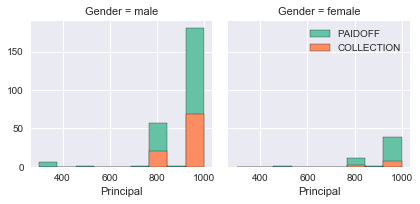

In [44]:
bins = np.linspace(df2.Principal.min(), df2.Principal.max(), 10)

sns.set()
plot1 = sns.FacetGrid(df2, col = 'Gender', hue = 'loan_status', palette = 'Set2', col_wrap = 2)
plot1.map(plt.hist, 'Principal', bins = bins, ec = 'k')

plot1.axes[-1].legend()

In [54]:
df2.groupby('Gender')['loan_status'].value_counts(normalize = True) #contagem normalizada dos status de empréstimo agrupada por gênero

Gender  loan_status
female  PAIDOFF        0.841270
        COLLECTION     0.158730
male    PAIDOFF        0.732938
        COLLECTION     0.267062
Name: loan_status, dtype: float64

Note que as mulheres pagam 84% dos empréstimos que realizam (e também fazem emprestimos menores) ao passo que apenas 73% dos homens pagam seus empréstimos. Assim o gênero pode ser uma característica interessante para essa classificação:

In [55]:
df2.replace(to_replace = ['male', 'female'], value = [0, 1], inplace = True) #transforma entrada categórica em númérica: male = 0; female = 1

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


** Distribuição da idade por gênero **

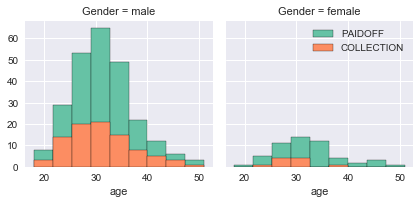

In [49]:
bins2 = np.linspace(df2.age.min(), df2.age.max(), 10)
sns.set()
plot2 = sns.FacetGrid(df2, col = 'Gender', hue = 'loan_status', palette = 'Set2', col_wrap = 2)
plot2.map(plt.hist, 'age', bins = bins2, ec ='k')

plot2.axes[-1].legend()

Tanto para homens como para mulheres parece que a inadimplência se concentra entre 20 e 30 anos

** Dia da Semana em que os empréstimos são feitos **

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


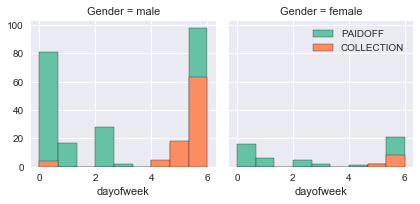

In [50]:
df2['dayofweek'] = df2.effective_date.dt.dayofweek
bins3 = np.linspace(df2.dayofweek.min(), df2.dayofweek.max(), 10)

sns.set()
plot3 = sns.FacetGrid(df2, col = 'Gender', hue = 'loan_status', palette = 'Set2', col_wrap = 2)
plot3.map(plt.hist, 'dayofweek', bins = bins3, ec = 'k')

plot3.axes[-1].legend()

Note que os empréstimos realizados no final de semana (entre 4 e 6) tendem a não ser pagos, segundo este dataset. Por isso, saber se o empréstimo foi realizado no final de semana ou não pode ser um parâmetro interessante:

In [56]:
df2['weekend'] = df2.dayofweek.apply(lambda x: 1 if (x>3) else 0)
print(df2.head())

  loan_status  Principal  terms effective_date   due_date  age  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   50   
2     PAIDOFF       1000     30     2016-09-08 2016-10-07   33   
3     PAIDOFF       1000     15     2016-09-08 2016-09-22   27   
4     PAIDOFF       1000     30     2016-09-09 2016-10-08   28   

              education  Gender  dayofweek  weekend  
0  High School or Below       0          3        0  
1              Bechalor       1          3        0  
2              Bechalor       1          3        0  
3               college       0          3        0  
4               college       1          4        1  


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** Distribuição da quantia de empréstimo por nível de escolaridade **

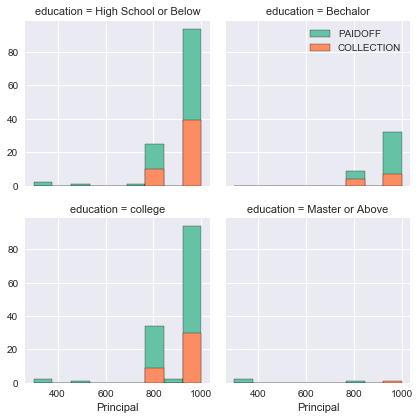

In [66]:
sns.set()
plot4 = sns.FacetGrid(df2, col = 'education', hue = 'loan_status', palette = 'Set2', col_wrap = 2)
plot4.map(plt.hist, 'Principal', bins = bins, ec = 'k')

plot4.axes[1].legend()

In [68]:
df2.groupby('education')['loan_status'].value_counts(normalize = True) #contagem normalizada do status do empréstimo agrupada por nível de escolaridade

education             loan_status
Bechalor              PAIDOFF        0.788462
                      COLLECTION     0.211538
High School or Below  PAIDOFF        0.715116
                      COLLECTION     0.284884
Master or Above       PAIDOFF        0.750000
                      COLLECTION     0.250000
college               PAIDOFF        0.773256
                      COLLECTION     0.226744
Name: loan_status, dtype: float64

A escolaridade também parece ser um critério interessante

In [76]:
education = pd.get_dummies(df2.education) #transforma as variáveis categóricas da coluna education em atributos binários

df2 = pd.concat([df2, education], axis = 1)
df2.drop(columns = 'education', inplace = True)

print(education.head())
print(df2.head())

   Bechalor  High School or Below  Master or Above  college
0         0                     1                0        0
1         1                     0                0        0
2         1                     0                0        0
3         0                     0                0        1
4         0                     0                0        1
  loan_status  Principal  terms effective_date   due_date  age  Gender  \
0     PAIDOFF       1000     30     2016-09-08 2016-10-07   45       0   
1     PAIDOFF       1000     30     2016-09-08 2016-10-07   50       1   
2     PAIDOFF       1000     30     2016-09-08 2016-10-07   33       1   
3     PAIDOFF       1000     15     2016-09-08 2016-09-22   27       0   
4     PAIDOFF       1000     30     2016-09-09 2016-10-08   28       1   

   dayofweek  weekend  Bechalor  High School or Below  Master or Above  \
0          3        0         0                     1                0   
1          3        0         1                

** Distribuição da quantia de empréstimo por vencimento **

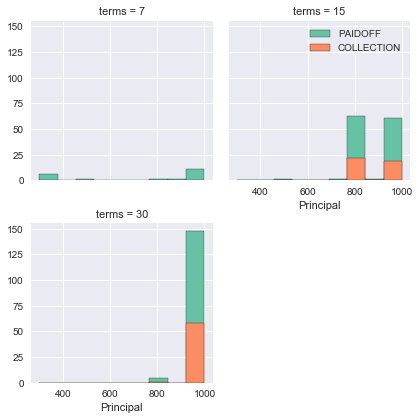

In [70]:
sns.set()
plot5 = sns.FacetGrid(df2, col = 'terms', hue = 'loan_status',palette = 'Set2', col_wrap = 2)
plot5.map(plt.hist, 'Principal', bins = bins, ec = 'k')

plot5.axes[1].legend()

In [77]:
df2.groupby('terms')['loan_status'].value_counts(normalize = True) #contagem normalizada os status de empréstimo agrupadas por termos

terms  loan_status
7      PAIDOFF        1.000000
15     PAIDOFF        0.755952
       COLLECTION     0.244048
30     PAIDOFF        0.721698
       COLLECTION     0.278302
Name: loan_status, dtype: float64

Os termos do empréstimo também parece ser importante, com atenção especial para os empréstimos semanais que, segundo o dataset, são sempre pagos.

Dadas as considerações anteriores, os parâmetros selecionados para modelagem serão:

* Principal
* terms
* age
* Gender
* weekend
* Nível de educação


In [79]:
features  = df2.drop(columns = ['loan_status', 'effective_date', 'due_date', 'dayofweek'])

print(features.head())

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   50       1        0         1                     0   
2       1000     30   33       1        0         1                     0   
3       1000     15   27       0        0         0                     0   
4       1000     30   28       1        1         0                     0   

   Master or Above  college  
0                0        0  
1                0        0  
2                0        0  
3                0        1  
4                0        1  


Assim:

In [82]:
X = features
y = df2.loan_status.values

print(X.head())
print(y[0:5])

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   50       1        0         1                     0   
2       1000     30   33       1        0         1                     0   
3       1000     15   27       0        0         0                     0   
4       1000     30   28       1        1         0                     0   

   Master or Above  college  
0                0        0  
1                0        0  
2                0        0  
3                0        1  
4                0        1  
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


# Normalização, treino e teste